In [1]:
import pandas as pd
import ast

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
filelist = pd.read_csv("G:\My Drive\EchoNet\FileList.csv")
filelist

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL
...,...,...,...,...,...,...,...,...,...
10024,0X234005774F4CB5CD,51.724743,47.065329,97.493690,768,1040,50,127,TRAIN
10025,0X2DC68261CBCC04AE,62.187781,26.333478,69.642772,768,1024,50,66,TRAIN
10026,0X35291BE9AB90FB89,62.070762,49.064338,129.357561,768,1024,50,208,TRAIN
10027,0X6C435C1B417FDE8A,59.635257,57.721170,142.998978,768,1024,50,166,TRAIN


## Simple without segmentation

In [ ]:
train_features = pd.read_csv("G:\\My Drive\\EchoNet\\output_predict\\simple_without_segm\\train.csv")
train_features

In [ ]:
test_features = pd.read_csv("G:\\My Drive\\EchoNet\\output_predict\\simple_without_segm\\test.csv")
test_features

In [ ]:
filelist_train = filelist[filelist['Split'] == "TRAIN"]
filelist_test = filelist[filelist['Split'] == "TEST"]
print("Size of train:{}".format(filelist_train.shape[0]))
print("Size of test:{}".format(filelist_test.shape[0]))
print("Unique size of test:{}".format(test_features['Filename'].nunique()))
filelist_lst = filelist_test['FileName'].to_list()
print("Missing videos:{}".format(set([s + ".avi" for s in filelist_lst]).difference(test_features['Filename'].unique())))
print(train_features.columns)


In [ ]:
# Building the features for train set
features_list = ['Size','Perimeter','LongAxis','ShortAxis1','ShortAxis2']
features_train_final = []
for ftrain in filelist_train['FileName'].to_list():
    ftrain_avi = ftrain + ".avi"
    if ftrain_avi in train_features['Filename'].to_list():
        train_example_rows = train_features[train_features['Filename'] == ftrain_avi]
        train_example_rows = train_example_rows[features_list]
        train_example_lst = train_example_rows.values.tolist()
        train_example = [ftrain_avi] + train_example_lst[0] + train_example_lst[1]
        ## Length of diastole
        length_df = train_features[train_features['Filename'] == ftrain_avi][['LTop','LBottom','LLeft','LRight']]
        train_example += length_df.values.tolist()[1] # Only diastole
        ##
        targets = filelist_train[filelist_train['FileName'] ==  ftrain][['EF','ESV','EDV']]
        train_example += targets.values.tolist()[0]
        features_train_final.append(train_example)
features_train_df = pd.DataFrame(features_train_final)
features_train_df.columns = ['FileName','Size_S','Perimeter_S','LongAxis_S','ShortAxis1_S','ShortAxis2_S',
                                        'Size_D','Perimeter_D','LongAxis_D','ShortAxis1_D','ShortAxis2_D',
                                        'LTop','LBottom','LLeft','LRight',
                                        'EF','ESV','EDV']
# features_train_df.columns = ['FileName','Size_S','Perimeter_S','LongAxis_S','ShortAxis1_S','ShortAxis2_S',
#                                         'Size_D','Perimeter_D','LongAxis_D','ShortAxis1_D','ShortAxis2_D',
#                                         'EF','ESV','EDV']

In [ ]:
features_train_df

In [ ]:
# (Optional) APPLY NORMALIZATION WITH LONG AXIS - TRAINSET #
features_train_df['Perimeter_S'] = features_train_df['Perimeter_S'] / features_train_df['LongAxis_D']
features_train_df['LongAxis_S'] = features_train_df['LongAxis_S'] / features_train_df['LongAxis_D']
features_train_df['ShortAxis1_S'] = features_train_df['ShortAxis1_S'] / features_train_df['LongAxis_D']
features_train_df['ShortAxis2_S'] = features_train_df['ShortAxis2_S'] / features_train_df['LongAxis_D']
features_train_df['Perimeter_D'] = features_train_df['Perimeter_D'] / features_train_df['LongAxis_D']
features_train_df['ShortAxis1_D'] = features_train_df['ShortAxis1_D'] / features_train_df['LongAxis_D']
features_train_df['ShortAxis2_D'] = features_train_df['ShortAxis2_D'] / features_train_df['LongAxis_D']
features_train_df['LTop'] = features_train_df['LTop'] / features_train_df['LongAxis_D']
features_train_df['LBottom'] = features_train_df['LBottom'] / features_train_df['LongAxis_D']
features_train_df['LLeft'] = features_train_df['LLeft'] / features_train_df['LongAxis_D']
features_train_df['LRight'] = features_train_df['LRight'] / features_train_df['LongAxis_D']


In [ ]:
# Building the features for test set
features_test_final = []
for ftest in filelist_test['FileName'].to_list():
    ftest_avi = ftest + ".avi"
    if ftest_avi in test_features['Filename'].to_list():
        test_example_rows = test_features[test_features['Filename'] == ftest_avi]
        test_example_systole = test_example_rows[test_example_rows['ComputerSmall'] == 1]
        test_example_diastole = test_example_rows[test_example_rows['ComputerLarge'] == 1]
        if test_example_systole.shape[0] == 0 or test_example_diastole.shape[0] == 0:
            print("Problematic entry without systole or diastole{}".format(ftest_avi))
        test_example_systole = test_example_systole.groupby("Filename").mean()
        test_example_diastole = test_example_diastole.groupby("Filename").mean()
        test_example_systole = test_example_systole[features_list].values.tolist()
        test_example_diastole = test_example_diastole[features_list].values.tolist()
        test_example = [ftest_avi] + test_example_systole[0] + test_example_diastole[0]
        ## Length of diastole
        length_df = test_example_rows[test_example_rows['ComputerLarge'] == 1]
        length_df = length_df[(length_df['LTop'] > 0) | (length_df['LBottom'] > 0) | (length_df['LLeft'] > 0) | (length_df['LRight'] > 0)]
        if length_df.shape[0] == 0: # If diastole is first in the video get the systole length
            length_df = test_example_rows[test_example_rows['ComputerSmall'] == 1]
            length_df = length_df[(length_df['LTop'] > 0) | (length_df['LBottom'] > 0) | (length_df['LLeft'] > 0) | (length_df['LRight'] > 0)]
        length_df = length_df.groupby("Filename").mean()
        test_example += length_df[['LTop','LBottom','LLeft','LRight']].values.tolist()[0]
        ##
        targets = filelist_test[filelist_test['FileName'] ==  ftest][['EF','ESV','EDV']]
        test_example += targets.values.tolist()[0]
        features_test_final.append(test_example)
features_test_df = pd.DataFrame(features_test_final)
features_test_df.columns = ['FileName','Size_S','Perimeter_S','LongAxis_S','ShortAxis1_S','ShortAxis2_S',
                                       'Size_D','Perimeter_D','LongAxis_D','ShortAxis1_D','ShortAxis2_D',
                                       'LTop','LBottom','LLeft','LRight',
                                       'EF','ESV','EDV']
# features_test_df.columns = ['FileName','Size_S','Perimeter_S','LongAxis_S','ShortAxis1_S','ShortAxis2_S',
#                                        'Size_D','Perimeter_D','LongAxis_D','ShortAxis1_D','ShortAxis2_D',
#                                        'EF','ESV','EDV']                                       

In [ ]:
# APPLY NORMALIZATION WITH LONG AXIS (TESTSET) #
features_test_df['Perimeter_S'] = features_test_df['Perimeter_S'] / features_test_df['LongAxis_D']
features_test_df['LongAxis_S'] = features_test_df['LongAxis_S'] / features_test_df['LongAxis_D']
features_test_df['ShortAxis1_S'] = features_test_df['ShortAxis1_S'] / features_test_df['LongAxis_D']
features_test_df['ShortAxis2_S'] = features_test_df['ShortAxis2_S'] / features_test_df['LongAxis_D']
features_test_df['Perimeter_D'] = features_test_df['Perimeter_D'] / features_test_df['LongAxis_D']
features_test_df['ShortAxis1_D'] = features_test_df['ShortAxis1_D'] / features_test_df['LongAxis_D']
features_test_df['ShortAxis2_D'] = features_test_df['ShortAxis2_D'] / features_test_df['LongAxis_D']

features_test_df['LTop'] = features_test_df['LTop'] / features_test_df['LongAxis_D']
features_test_df['LBottom'] = features_test_df['LBottom'] / features_test_df['LongAxis_D']
features_test_df['LLeft'] = features_test_df['LLeft'] / features_test_df['LongAxis_D']
features_test_df['LRight'] = features_test_df['LRight'] / features_test_df['LongAxis_D']

In [ ]:
features_test_df

In [ ]:
import xgboost
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor


In [ ]:
# regressor = xgboost.XGBRegressor(random_state=1,n_estimators=500,max_depth=10)
# regressor = LinearRegression()
# regressor = LinearSVR()
# regressor = SVR()
# regressor = MLPRegressor()
# regressor = SGDRegressor()
regressor = RandomForestRegressor(random_state=1,n_estimators=500)
X_train = features_train_df.drop(["FileName",'EF','ESV','EDV'],axis=1).to_numpy()
y_train = features_train_df['EF'].to_list()
regressor.fit(X_train,y_train)

In [ ]:
X_test = features_test_df.drop(["FileName",'EF','ESV','EDV'],axis=1).to_numpy()
y_test = features_test_df['EF'].to_list()
predictions = regressor.predict(X_test)

In [ ]:
predictions_size = -((features_test_df['Size_D'] - features_test_df['Size_S']) / features_test_df['Size_D']) * 100

In [ ]:
import numpy as np
predictions_size.replace([np.inf, -np.inf],np.nan,inplace=True)
predictions_size.fillna(0,inplace=True)


In [ ]:
print(predictions_size[:10])
print(predictions[:10])
print(y_test[:10])
print(y_train[:10])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

mae = mean_absolute_error(y_test,predictions)
rmse = math.sqrt(mean_squared_error(y_test,predictions))
r2 = r2_score(y_test,predictions)

mae_s = mean_absolute_error(y_test,predictions_size)
rmse_s = math.sqrt(mean_squared_error(y_test,predictions_size))
r2_s = r2_score(y_test,predictions_size)

In [ ]:
print("MAE:{}".format(mae))
print("RMSE:{}".format(rmse))
print("R2:{}".format(r2))

print("MAE:{}".format(mae_s))
print("RMSE:{}".format(rmse_s))
print("R2:{}".format(r2_s))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes,scoring='neg_mean_absolute_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # fit_times_mean = np.mean(fit_times, axis=1)
    # fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

In [ ]:
plot_learning_curve(regressor,"Learning Curve MAE",X_train,y_train,None,None,None)

In [ ]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

### Compute the length at % point 

## Simple with segmentation

In [66]:
from scipy.spatial.distance import euclidean
def compute_length(df_example_rows,stop_frames):
    stop_frames = sorted(stop_frames)
    lengths = dict()
    for i in range(0,len(stop_frames)):
        if i == 0:
            smaller_frames = df_example_rows[df_example_rows['Frame'] <= stop_frames[i]]
        else:
            smaller_frames = df_example_rows[(df_example_rows['Frame'] <= stop_frames[i]) & (df_example_rows['Frame'] > stop_frames[i-1])]
        bottomx_sum = smaller_frames['BottomX'].sum()
        bottomy_sum = smaller_frames['BottomY'].sum()
        topx_sum = smaller_frames['TopX'].sum()
        topy_sum = smaller_frames['TopY'].sum()
        leftx_sum = smaller_frames['LeftX'].sum()
        lefty_sum = smaller_frames['LeftY'].sum()
        rightx_sum = smaller_frames['RightX'].sum()
        righty_sum = smaller_frames['RightY'].sum()
        bottom_len = euclidean([0,0],[bottomx_sum,bottomy_sum])
        top_len = euclidean([0,0],[topx_sum,topy_sum])
        left_len = euclidean([0,0],[leftx_sum,lefty_sum])
        right_len = euclidean([0,0],[rightx_sum,righty_sum])
        lengths[stop_frames[i]] = [top_len,bottom_len,left_len,right_len]
    return lengths

In [67]:
from skimage.draw import line
from scipy.spatial.distance import euclidean
from collections import defaultdict
import statistics
def curve_shift(df,stop_frames):
    stop_frames = sorted(stop_frames)
    curve = dict()
    for stop_frame in stop_frames:
        curve[stop_frame] = []
    curve_avg = dict()
    curve_std = dict()
    for i in range(0,len(stop_frames)):
            if i == 0:
                curve[stop_frames[i]].append(0)
            else:
                centroid = df[df['Frame'] == stop_frames[i]]['Centroid'].iloc[0]
                p_boundaries = df[df['Frame'] == stop_frames[i - 1]]['Boundaries'].iloc[0]
                c_boundaries = df[df['Frame'] == stop_frames[i]]['Boundaries'].iloc[0]
                for x,y in p_boundaries:
                    ll = line(x,y,round(centroid[0]),round(centroid[1]))
                    for (lx,ly) in zip(ll[0],ll[1]):
                        if [lx,ly] in c_boundaries:
                            distance = euclidean([x,y],[lx,ly])
                            curve[stop_frames[i]].append(distance)

            if len(curve[stop_frames[i]]) > 1:
                curve_avg[stop_frames[i]] = sum(curve[stop_frames[i]]) / len(curve[stop_frames[i]])
                curve_std[stop_frames[i]] = statistics.stdev(curve[stop_frames[i]])
            else:
                curve_avg[stop_frames[i]] = sum(curve[stop_frames[i]])
                curve_std[stop_frames[i]] = 0
    return curve_avg,curve_std

                            

In [5]:

def create_features(df,half_frame = True, train = True, length = True, shift=True, avg = True):
    features = []
    features_list = ['Size','Perimeter','LongAxis','ShortAxis1','ShortAxis2']
    feature_columns = ['Size_S','Perimeter_S','LongAxis_S','ShortAxis1_S','ShortAxis2_S',
                       'Size_D','Perimeter_D','LongAxis_D','ShortAxis1_D','ShortAxis2_D']
    if length: 
        features_list.extend(['LTop','LBottom','LLeft','LRight'])
        feature_columns = ['Size_S','Perimeter_S','LongAxis_S','ShortAxis1_S','ShortAxis2_S','LTop_S','LBottom_S','LLeft_S','LRight_S',
                       'Size_D','Perimeter_D','LongAxis_D','ShortAxis1_D','ShortAxis2_D','LTop_D','LBottom_D','LLeft_D','LRight_D']
    if shift:
        features_list.extend(['ShiftAvg','ShiftStd'])
        feature_columns = ['Size_S','Perimeter_S','LongAxis_S','ShortAxis1_S','ShortAxis2_S','LTop_S','LBottom_S','LLeft_S','LRight_S','ShiftAvg_S','ShiftStd_S',
                       'Size_D','Perimeter_D','LongAxis_D','ShortAxis1_D','ShortAxis2_D','LTop_D','LBottom_D','LLeft_D','LRight_D', 'ShiftAvg_D', 'ShiftStd_D']
    
      
    videonames = df['Filename'].unique()
    for videoname in videonames:
        df_example_rows = df[df['Filename'] == videoname]
        df_example_systole = df_example_rows[df_example_rows['ComputerSmall'] == 1]
        df_example_diastole = df_example_rows[df_example_rows['ComputerLarge'] == 1]
        if df_example_systole.shape[0] == 0 or df_example_diastole.shape[0] == 0:
            if train:
                if df_example_systole.shape[0] == 0:
                    df_example_systole = df_example_rows[df_example_rows['HumanSmall'] == 1]
                if df_example_diastole.shape[0] == 0:
                    df_example_diastole = df_example_rows[df_example_rows['HumanLarge'] == 1]
            else:
                if df_example_systole.shape[0] == 0:
                    df_example_systole = df_example_rows[df_example_rows['Size'] == df_example_rows['Size'].min()]
                if df_example_diastole.shape[0] == 0:
                    df_example_diastole = df_example_rows[df_example_rows['Size'] ==  df_example_rows['Size'].max()]
            
            print("Problematic entry without systole or diastole{}".format(videoname))
        stop_frames = df_example_diastole['Frame'].to_list() + df_example_systole['Frame'].to_list()
        if half_frame:
            systole_frames = df_example_systole['Frame'].to_list()
            diastole_frames = df_example_diastole['Frame'].to_list()
            sd_frames =  systole_frames + diastole_frames
            sd_frames = sorted(sd_frames)
            half_frames = []
            for frame_index in range(1,len(sd_frames)):
                if (sd_frames[frame_index] in systole_frames and sd_frames[frame_index - 1] in diastole_frames) or (sd_frames[frame_index - 1] in systole_frames and sd_frames[frame_index] in diastole_frames):
                    half_point = (sd_frames[frame_index] - sd_frames[frame_index -1]) // 2 # Integer division
                    half_frames.append(sd_frames[frame_index -1] + half_point)
            df_example_halfs = df_example_rows[df_example_rows['Frame'].isin(half_frames)]
            stop_frames.extend(df_example_halfs['Frame'].to_list())
                
        if length:
            lengths = compute_length(df_example_rows,stop_frames)
            for stop_frame in stop_frames:
                if stop_frame in df_example_diastole['Frame'].to_list():
                    df_example_diastole.loc[df_example_diastole['Frame'] == stop_frame,['LTop','LBottom','LLeft','LRight']] = lengths[stop_frame]
                if stop_frame in df_example_systole['Frame'].to_list():
                    df_example_systole.loc[df_example_systole['Frame'] == stop_frame,['LTop','LBottom','LLeft','LRight']] = lengths[stop_frame]
                if half_frame:
                    if stop_frame in df_example_halfs['Frame'].to_list():
                        df_example_halfs.loc[df_example_halfs['Frame'] == stop_frame,['LTop','LBottom','LLeft','LRight']] = lengths[stop_frame]
        
        if shift:
            shift_avg, shift_std = curve_shift(df_example_rows,stop_frames)
            for stop_frame in stop_frames:
                if stop_frame in df_example_diastole['Frame'].to_list():
                    df_example_diastole.loc[df_example_diastole['Frame'] == stop_frame,['ShiftAvg','ShiftStd']] = shift_avg[stop_frame], shift_std[stop_frame]
                if stop_frame in df_example_systole['Frame'].to_list():
                    df_example_systole.loc[df_example_systole['Frame'] == stop_frame,['ShiftAvg','ShiftStd']] = shift_avg[stop_frame], shift_std[stop_frame]
                if half_frame:
                    if stop_frame in df_example_halfs['Frame'].to_list():
                        df_example_halfs.loc[df_example_halfs['Frame'] == stop_frame,['ShiftAvg','ShiftStd']] = shift_avg[stop_frame], shift_std[stop_frame]
        
        if avg:
            df_example_systole = df_example_systole.groupby("Filename").mean()
            df_example_diastole = df_example_diastole.groupby("Filename").mean()
        else:
            df_example_systole = df_example_systole.groupby("Filename").sample()
            df_example_diastole = df_example_diastole.groupby("Filename").sample()
        df_example_systole = df_example_systole[features_list].values.tolist()
        df_example_diastole = df_example_diastole[features_list].values.tolist()
        if half_frame:
            if avg:
                df_example_halfs = df_example_halfs.groupby("Filename").mean()
            else:
                df_example_halfs = df_example_halfs.groupby("Filename").sample()
            df_example_halfs = df_example_halfs[features_list].values.tolist()
            df_example = [videoname] + df_example_systole[0] + df_example_diastole[0] + df_example_halfs[0]
        else:
            df_example = [videoname] + df_example_systole[0] + df_example_diastole[0]
        features.append(df_example)    
    
    # print(features)
    features_df = pd.DataFrame(features)
    print(features_df.columns)
    if half_frame:
        features_df.columns = ['FileName'] + feature_columns + ['Size_H','Perimeter_H','LongAxis_H','ShortAxis1_H','ShortAxis2_H','LTop_H','LBottom_H','LLeft_H','LRight_H','ShiftAvg_H','ShiftStd_H']
    else:
        features_df.columns = ['FileName'] + feature_columns

    return features_df
        

## Simple with Circles (Average)

In [85]:
from decimal import Decimal
def create_features_circles_average(df):
    videonames = df['Filename'].unique()
    for videoname in videonames:
        df_example_rows = df[df['Filename'] == videoname]
        stop_frames = df_example_rows['Frame'].to_list()
        lengths = compute_length(df_example_rows,stop_frames)
        shift_avg, shift_std = curve_shift(df_example_rows,stop_frames)
        for stop_frame in stop_frames:
            df_example_rows.loc[df_example_rows['Frame'] == stop_frame,['LTop','LBottom','LLeft','LRight']] = lengths[stop_frame]
            df_example_rows.loc[df_example_rows['Frame'] == stop_frame,['ShiftAvg','ShiftStd']] = shift_avg[stop_frame], shift_std[stop_frame]
        df_example_rows['CirclePart'] = [float(Decimal(i)%1) for i in df_example_rows['Circle'].to_list()]
        df_example_rows.drop(['Filename','Frame','Circle','HumanLarge','HumanSmall','ComputerLarge','ComputerSmall'],inplace=True,axis=1)
        df_example_rows = df_example_rows.groupby('CirclePart').mean()
        df_example_rows.drop(['CirclePart'],axis=1)
        
        print(df_example_rows.to_numpy().flatten())
        break
    

    

## Simple with Circles (3 Circle)

In [ ]:
def create_features_circles(df,threshold_circle=3):
    features = []
    circle_parts_whole = [0.125,0.25,0.375,0.5,0.625,0.75,0.875,1.0]
    features_names = ['Size','Perimeter','LongAxis','ShortAxis1','ShortAxis2','LTop','LBottom','LLeft','LRight','ShiftAvg','ShiftStd']
    df_groups = df.groupby('Filename')
    for group_name, df_group in df_groups:
        
        
        max_circle = df_group['Circle'].max()
        max_frame = df_group['Frame'].max()
        
        if max_circle < 3:
            print(group_name)
            print(max_circle)
            from_circle = 0
            to_circle = 1
            if max_circle % 1 != 0:
                from_circle = 0.5
                to_circle = 1
                copy_circle = df_group[(df_group['Circle'] <=to_circle) & (df_group['Circle'] > from_circle)].copy()
                copy_circle['Circle'] = [max_circle + i for i in circle_parts_whole[:4]]
                copy_circle['Frame'] = [max_frame + i  for i in copy_circle['Frame'].to_list()]
                # display(copy_circle)
                df_group = df_group.append(copy_circle,ignore_index=True)
                # display(df_group)
                from_circle = to_circle
                to_circle += 1
                max_circle = df_group['Circle'].max()
                print(max_circle)
                # print(df_group['Circle'].to_list())
            while max_circle < threshold_circle:
                copy_circle = df_group[(df_group['Circle'] <=to_circle) & (df_group['Circle'] > from_circle)].copy()
                copy_circle['Circle'] = [max_circle + i for i in circle_parts_whole]
                copy_circle['Frame'] = [max_frame + i  for i in copy_circle['Frame'].to_list()]
                df_group = df_group.append(copy_circle,ignore_index=True)
                from_circle = to_circle
                to_circle += 1
                max_circle = df_group['Circle'].max()
                print(max_circle)
            display(df_group)
        else:
            continue
        # display(df_group)




### Parsing Files

In [59]:
data = pd.read_csv("G:\\My Drive\\EchoNet\\output_20peak\\features\\circle_train.csv",quotechar='"',sep=',',converters={"Boundaries":ast.literal_eval,'Centroid':ast.literal_eval})


In [60]:
f_grouped = data.groupby('Filename')
remove = []
for group_name, df_group in f_grouped:
    if df_group['Circle'].max() == 0.5:
        remove.append(group_name)
print(remove)

['0X114DED900F0C2D7D.avi', '0X1631C52C25D15DEE.avi', '0X19B9109694DE642.avi', '0X1C8054277A139381.avi', '0X1E41619BEA0A4042.avi', '0X2A55659AE64722AA.avi', '0X2DE6FC105DDE8B38.avi', '0X2EFB608A1CC1437F.avi', '0X317B80B024DEF142.avi', '0X37EED937EE5D531F.avi', '0X385071ADD66846AD.avi', '0X3F6A65114504DCE4.avi', '0X4A317939C584CC0D.avi', '0X4A4190933DB9D3F2.avi', '0X4A8E3E2FB03F2A52.avi', '0X525F58503C9356EE.avi', '0X561EA6D2BA7109CC.avi', '0X5B4D0D38F575846D.avi', '0X5D81397DB541670A.avi', '0X5EED7E17AC927985.avi', '0X5FE6439A0CCEF482.avi', '0X60A115AC08C5AA98.avi', '0X6517121A1CC175DC.avi', '0X6FAD9DF07824297B.avi', '0X7118ED94A443E8E7.avi', '0X753AA26EA352BBB.avi', '0X796FE72A47DAC27A.avi', '0X9E181B942CACADF.avi']


In [61]:
f_grouped = data.groupby('Filename')
maxs = []
mins = []
for group_name, df_group in f_grouped:
    maxs.append(df_group['Circle'].max())
    mins.append(df_group['Circle'].min())


In [62]:
from collections import Counter

print(Counter(maxs))
print(Counter(mins))

Counter({3.5: 5127, 2.5: 825, 3.375: 224, 4.5: 222, 1.5: 175, 3.0: 154, 4.0: 96, 2.0: 83, 3.875: 53, 5.5: 50, 2.875: 38, 3.25: 37, 5.0: 30, 1.0: 29, 0.5: 28, 2.375: 28, 4.375: 26, 2.75: 16, 6.0: 11, 4.25: 10, 4.75: 10, 6.5: 10, 1.375: 10, 19.5: 10, 1.875: 10, 3.75: 9, 7.0: 9, 5.375: 9, 4.875: 8, 2.25: 8, 9.5: 7, 3.125: 7, 3.625: 6, 6.375: 5, 0.0: 4, 5.25: 4, 2.625: 4, 8.5: 4, 7.5: 4, 6.875: 3, 7.375: 3, 14.5: 3, 8.125: 2, 5.875: 2, 4.125: 2, 0.875: 2, 11.5: 2, 13.375: 2, 14.375: 2, 0.375: 2, 4.625: 2, 5.625: 1, 17.75: 1, 8.375: 1, 9.0: 1, 19.875: 1, 12.875: 1, 14.75: 1, 19.375: 1, 2.125: 1, 7.125: 1, 13.5: 1, 0.75: 1, 18.875: 1, 8.875: 1, 1.25: 1, 8.0: 1, 6.25: 1, 19.125: 1, 10.25: 1, 18.375: 1, 5.75: 1, 9.25: 1, 12.5: 1, 5.125: 1, 12.0: 1, 22.875: 1, 18.0: 1, 6.625: 1, 7.75: 1, 0.125: 1, 29.125: 1, 17.0: 1})
Counter({0.5: 7213, 0.0: 246})


In [64]:
clean_data = data[~data['Filename'].isin(remove)]
clean_data['Filename'].nunique()

7431

In [86]:
create_features_circles_average(clean_data.copy())

[ 1.14866667e+03  1.38972944e+02  5.26523780e+01  2.93303877e+01
  1.00000000e+00  0.00000000e+00 -3.33333333e-01 -3.33333333e-01
  6.66666667e-01 -1.33333333e+00 -1.00000000e+00 -1.33333333e+00
 -3.33333333e-01  3.33333333e-01  8.04737854e-01  1.67325495e+00
  1.38742589e+00  7.12653474e-01  7.82778312e-01  9.22666667e+02
  1.25740115e+02  4.79222400e+01  2.65979639e+01  1.55502829e+01
 -3.33333333e-01  3.33333333e-01 -6.66666667e-01  0.00000000e+00
  1.00000000e+00  3.33333333e-01  6.66666667e-01  3.33333333e-01
  4.71404521e-01  6.66666667e-01  1.05409255e+00  7.45355992e-01
  2.16457061e+00  1.17062968e+00  6.92000000e+02  1.10473785e+02
  4.16832996e+01  2.27076846e+01  7.06199563e+00  2.36666667e+01
  1.53333333e+01 -2.40000000e+01 -1.36666667e+01  1.13333333e+01
 -1.16666667e+01 -4.00000000e+00  1.40000000e+01  2.87747595e+01
  2.81182213e+01  1.68085513e+01  1.54375116e+01  2.65777642e+00
  1.57662797e+00  6.96000000e+02  1.11335714e+02  4.19160933e+01
  2.28327227e+01  1.00000

## General Parsing Files 

### Merging Files Circle

In [ ]:
train_data = pd.read_csv("G:\\My Drive\\EchoNet\\output_20peak\\features\\testn.csv",quotechar='"',sep=',',converters={"Boundaries":ast.literal_eval,'Centroid':ast.literal_eval})
train_data_circle = pd.read_csv("G:\\My Drive\\EchoNet\\output_20peak\\features\\test_with_circles.csv")
display(train_data)
display(train_data_circle)

In [ ]:
train_data.info()

In [ ]:
# train_data['Filename']  
# train_data_circle['Filename'] = train_data_circle['Filename'].astype(str)
train_data['Combined_Name'] = train_data['Filename'] + train_data['Frame'].astype(str)
train_data_circle['Combined_Name'] = train_data_circle['Filename'] + train_data_circle['Frame'].astype(str)
merged = train_data.merge(train_data_circle,how='inner',on=['Combined_Name'])

In [ ]:
merged = merged.drop(['Filename_y','Frame_y','Combined_Name'],axis=1)
merged = merged.rename({'Filename_x':'Filename','Frame_x':'Frame'},axis=1)
merged

In [ ]:
merged.to_csv("G:\\My Drive\\EchoNet\\output_20peak\\features\\circle_test.csv",index=False)

### Train Data ###

In [11]:
train_data = pd.read_csv("G:\\My Drive\\EchoNet\\output_20peak\\features\\testn.csv",quotechar='"',sep=',',converters={"Boundaries":ast.literal_eval,'Centroid':ast.literal_eval})
train_data

,Filename,Frame,Size,Perimeter,HumanLarge,HumanSmall,ComputerSmall,ComputerLarge,LongAxis,ShortAxis1,...,LeftX,LeftY,RightX,RightY,LTop,LBottom,LLeft,LRight,Centroid,Boundaries
0,0X100CF05D141FF143.avi,0,1332,150.669048,0,0,0,0,58.523500,29.120440,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,"[54.231231231231234, 60.51426426426426]","[[22, 51], [22, 52], [22, 53], [23, 50], [23, ..."
1,0X100CF05D141FF143.avi,1,1343,152.911688,0,0,0,0,58.872744,30.083218,...,19,-28,0,28,57.939624,59.481089,33.837849,28.000000,"[53.54430379746835, 60.438570364854804]","[[21, 51], [21, 52], [22, 50], [22, 53], [22, ..."
2,0X100CF05D141FF143.avi,2,1310,150.083261,0,0,0,0,57.584720,28.792360,...,1,1,2,0,1.000000,1.000000,1.414214,2.000000,"[53.613740458015265, 60.563358778625954]","[[22, 51], [22, 52], [22, 53], [23, 50], [23, ..."
3,0X100CF05D141FF143.avi,3,1318,151.497475,0,0,0,0,58.189346,29.410882,...,-3,-1,-2,0,0.000000,1.414214,3.162278,2.000000,"[53.45068285280728, 60.59939301972686]","[[21, 52], [22, 51], [22, 53], [22, 54], [23, ..."
4,0X100CF05D141FF143.avi,4,1319,153.154329,0,0,0,0,58.309519,23.409400,...,-25,1,-24,-5,2.236068,1.000000,25.019992,24.515301,"[53.24336618650493, 60.55724033358605]","[[21, 51], [21, 52], [22, 50], [22, 53], [22, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226267,0XFE6E32991136338.avi,115,1270,142.669048,0,0,0,0,54.120237,30.413813,...,0,-1,-2,0,1.000000,1.000000,1.000000,2.000000,"[48.55511811023622, 62.51732283464567]","[[20, 57], [20, 58], [20, 59], [21, 52], [21, ..."
226268,0XFE6E32991136338.avi,116,1287,142.911688,0,0,0,0,53.851648,30.463092,...,1,0,3,1,2.236068,3.162278,1.000000,3.162278,"[48.7008547008547, 62.72494172494172]","[[20, 56], [20, 57], [20, 58], [20, 59], [20, ..."
226269,0XFE6E32991136338.avi,117,1259,142.325902,0,0,0,0,53.712196,27.730849,...,-16,-2,-16,-5,2.236068,0.000000,16.124515,16.763055,"[48.70373312152502, 62.695790309769656]","[[20, 57], [20, 58], [20, 59], [20, 60], [21, ..."
226270,0XFE6E32991136338.avi,118,1235,140.669048,0,0,0,0,53.235327,27.294688,...,-2,0,-3,-1,1.414214,2.236068,2.000000,3.162278,"[49.00161943319838, 62.73279352226721]","[[21, 53], [21, 54], [21, 55], [21, 56], [21, ..."


In [12]:
train_data = train_data[train_data['Size'] != 0]
train_data.shape[0]

226263

In [13]:
train_data = train_data[train_data['Centroid'] != 0]
train_data.shape[0]

226261

In [14]:
train_features = create_features(train_data,half_frame = False, train = False, length = True, shift=True, avg = True)
train_features


Problematic entry without systole or diastole0X333A6598916DD19.avi
Problematic entry without systole or diastole0X350E5D4955052AFA.avi
Problematic entry without systole or diastole0X4225D03BC0BFD7BA.avi
Problematic entry without systole or diastole0X47DBEA2F11240016.avi
Problematic entry without systole or diastole0X5F40FC2C2367EA92.avi
Problematic entry without systole or diastole0X700C7EFB75691A.avi
RangeIndex(start=0, stop=23, step=1)


,FileName,Size_S,Perimeter_S,LongAxis_S,ShortAxis1_S,ShortAxis2_S,LTop_S,LBottom_S,LLeft_S,LRight_S,...,Perimeter_D,LongAxis_D,ShortAxis1_D,ShortAxis2_D,LTop_D,LBottom_D,LLeft_D,LRight_D,ShiftAvg_D,ShiftStd_D
0,0X100CF05D141FF143.avi,818.000000,124.044679,48.887381,22.782834,1.207107,30.006071,29.200825,17.901808,16.142764,...,151.463973,58.638629,28.270513,1.414214,22.404040,19.990264,15.217699,14.057449,0.000000,0.000000
1,0X1012703CDC1436FE.avi,1692.000000,165.507882,60.172463,39.199761,1.103553,19.643449,21.047101,14.940158,16.438626,...,186.710678,66.289225,48.876764,1.276142,25.294431,25.892927,18.796658,19.570717,0.697897,0.616776
2,0X102CFB07F752AAE6.avi,814.000000,124.229708,49.223104,15.852532,1.000000,29.769612,29.651968,20.120354,21.425115,...,152.387157,57.420459,32.142517,1.138071,38.413951,37.788816,25.513021,26.965855,0.874733,0.580379
3,0X105B9EF57DE45DCB.avi,1323.000000,159.936815,62.399977,13.556011,1.310660,9.124929,3.783394,6.381543,14.664749,...,188.272775,71.372552,27.638007,1.276142,5.420142,4.576219,5.960439,9.635378,0.128686,0.173920
4,0X10A28877E97DF540.avi,953.333333,133.059572,51.035680,27.199309,1.138071,26.932971,19.858433,15.874259,16.312149,...,169.087326,64.387931,36.595487,1.276142,27.879178,19.710675,13.970261,17.510956,0.879937,0.804277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,0XECF82DC9301EE77.avi,739.750000,122.676407,49.203497,13.063650,4.673624,25.163551,19.564075,28.305493,24.482941,...,169.215584,62.742763,35.996994,1.276142,15.294844,5.835446,23.953675,28.146077,0.117851,0.213201
1272,0XF557EF658FD13D0.avi,772.750000,113.865747,42.251142,13.010408,1.103553,16.008753,17.424004,14.141602,9.284499,...,146.144517,54.291512,31.918816,10.059335,33.833564,35.054019,20.490831,11.053574,0.142857,0.171184
1273,0XF6661AF354401A5.avi,726.500000,122.555087,48.948382,10.487081,1.000000,17.708471,16.639808,17.038754,13.425820,...,150.454161,56.660687,11.167187,1.000000,19.972853,20.148735,36.537262,37.148998,0.574331,0.358740
1274,0XF829F634971A0F7.avi,750.000000,121.987067,45.583018,9.571134,1.103553,33.608095,28.167200,30.313828,29.862353,...,154.635546,58.360693,33.891039,1.414214,27.586158,19.501680,32.033161,25.483753,0.000000,0.000000


In [15]:
train_features.to_csv("G:\\My Drive\EchoNet\\output_20peak\\features_final\\test_woh_avg.csv",index=False)

## Merge files

In [3]:
all_filenames =  ['train1_woh_avg.csv','train2_woh_avg.csv','train3_woh_avg.csv']



base_folder = "G:\\My Drive\\EchoNet\\output_20peak\\features_final\\"
data = pd.DataFrame()
for filename in all_filenames:
    datafile = pd.read_csv(base_folder + filename, quotechar='"',sep=',',
                            # converters={"Boundaries":ast.literal_eval,'Centroid':ast.literal_eval},
                            # usecols=['Filename','Frame','ComputerLarge','ComputerSmall','Size','Perimeter','LongAxis','ShortAxis1','ShortAxis2','Centroid','LTop','LBottom','LLeft','LRight']
                            # usecols=['Filename','Frame']
                            )
    if data.shape[0] == 0:
        data = datafile
    else:
        data = pd.concat([data,datafile],ignore_index=True)

In [4]:
data.to_csv(base_folder + 'train_woh_avg.csv',index=False)

## Prediction

In [49]:
train_features = pd.read_csv("G:\\My Drive\EchoNet\\output_20peak\\features_final\\train_avg.csv")
test_features = pd.read_csv("G:\\My Drive\EchoNet\\output_20peak\\features_final\\test_avg.csv")
display(train_features)
display(test_features)


,FileName,Size_S,Perimeter_S,LongAxis_S,ShortAxis1_S,ShortAxis2_S,LTop_S,LBottom_S,LLeft_S,LRight_S,...,Perimeter_H,LongAxis_H,ShortAxis1_H,ShortAxis2_H,LTop_H,LBottom_H,LLeft_H,LRight_H,ShiftAvg_H,ShiftStd_H
0,0X1002E8FBACD08477.avi,646.50,107.237067,41.954434,20.595759,13.157257,13.355997,12.081393,11.751440,10.526566,...,117.049759,44.924910,24.335653,7.625730,25.932864,24.363961,16.070559,14.621097,2.401800,1.205909
1,0X1005D03EED19C65B.avi,526.25,101.790368,40.066340,17.132303,1.310660,42.228737,42.062017,25.125734,25.471811,...,115.406782,44.478479,20.374499,4.246337,12.287490,11.054981,14.385300,14.877591,1.708842,1.008165
2,0X10075961BC11C88E.avi,745.50,116.441125,44.309714,23.821677,1.103553,3.477160,5.891654,19.138004,19.068347,...,125.840620,47.337614,5.324331,1.207107,2.970336,3.586340,16.215928,20.357403,2.037734,1.414008
3,0X100E3B8D3280BEC5.avi,931.50,125.497475,48.019495,23.221635,1.000000,16.899204,14.859331,16.813481,14.444397,...,134.033009,50.896730,26.497890,9.766643,11.455296,9.703019,16.559960,15.015884,0.749492,0.792972
4,0X100E491B3CD58DE2.avi,1001.00,132.689863,49.739320,27.539788,1.103553,15.690226,14.988709,8.124358,10.955390,...,144.060762,53.618717,31.641701,13.735467,13.427140,12.130251,8.578860,9.505711,1.713209,1.180822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7454,0XF342DDFE30C0980.avi,1278.50,155.300776,57.708805,25.029209,1.207107,24.849130,16.484562,12.047405,19.761246,...,177.639610,64.921817,26.665713,6.659008,29.191516,22.144035,20.348899,26.268510,1.750812,1.051167
7455,0XF46CF63A2A1FA90.avi,677.00,112.169048,42.467084,18.828828,1.000000,34.434383,34.982782,18.381980,21.392811,...,121.870232,46.433479,26.480604,4.947025,9.275607,10.023700,8.746842,8.908850,1.826510,1.328676
7456,0XF4CA716E61ECD9F.avi,1176.75,148.275649,58.501066,24.654262,6.238718,34.683105,31.376335,25.913061,25.488597,...,169.117953,66.009722,30.689173,10.516503,28.531309,23.370284,20.445726,17.752051,2.435123,1.618713
7457,0XF526937B72090A6.avi,705.50,116.837572,45.153392,18.330937,1.000000,28.705869,24.129567,14.598128,12.099357,...,133.305087,51.344457,24.332309,4.794955,21.129420,17.528096,15.352254,15.221792,1.974306,0.877639


,FileName,Size_S,Perimeter_S,LongAxis_S,ShortAxis1_S,ShortAxis2_S,LTop_S,LBottom_S,LLeft_S,LRight_S,...,Perimeter_H,LongAxis_H,ShortAxis1_H,ShortAxis2_H,LTop_H,LBottom_H,LLeft_H,LRight_H,ShiftAvg_H,ShiftStd_H
0,0X100CF05D141FF143.avi,818.000000,124.044679,48.887381,22.782834,1.207107,27.049623,27.732891,15.658327,18.141758,...,139.887999,53.470138,19.416120,1.138071,4.731034,2.103539,14.099230,15.909052,1.277488,0.843496
1,0X1012703CDC1436FE.avi,1692.000000,165.507882,60.172463,39.199761,1.103553,19.471876,20.030269,15.187235,14.308084,...,176.030135,63.029491,43.237201,8.641610,16.432536,19.050882,12.150074,15.004674,2.400106,1.658452
2,0X102CFB07F752AAE6.avi,814.000000,124.229708,49.223104,15.852532,1.000000,17.185841,15.084801,11.835297,13.777712,...,137.561604,53.456511,27.316588,1.138071,20.785175,21.042346,14.135320,14.528681,2.214462,1.076679
3,0X105B9EF57DE45DCB.avi,1323.000000,159.936815,62.399977,13.556011,1.310660,5.292769,2.723231,6.627310,15.428542,...,176.811183,67.730598,25.447182,1.069036,18.313540,14.423089,7.870837,14.566812,2.173393,1.381447
4,0X10A28877E97DF540.avi,953.333333,133.059572,51.035680,27.199309,1.138071,23.756634,19.496108,12.726002,13.353949,...,156.305801,60.076719,32.563874,1.165685,26.292788,23.381027,15.750288,14.804669,1.514520,0.918191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,0XECF82DC9301EE77.avi,739.750000,122.676407,49.203497,13.063650,4.673624,22.721668,19.606387,26.879666,22.542806,...,157.063636,59.387132,30.363249,1.207107,9.415487,3.946075,11.517724,13.893034,2.013725,1.133470
1272,0XF557EF658FD13D0.avi,772.750000,113.865747,42.251142,13.010408,1.103553,34.964335,35.928253,20.704311,14.001106,...,131.066510,48.792756,28.719061,5.374686,30.110709,27.603267,16.383688,18.439551,1.624267,1.081075
1273,0XF6661AF354401A5.avi,726.500000,122.555087,48.948382,10.487081,1.000000,28.851255,26.033208,25.540428,24.153954,...,141.009319,53.707715,13.538963,1.069036,27.941517,26.916481,34.251613,33.665002,1.901610,1.277708
1274,0XF829F634971A0F7.avi,750.000000,121.987067,45.583018,9.571134,1.103553,29.619109,26.691961,27.870691,25.436378,...,139.254834,52.597705,23.954927,1.138071,7.466156,7.262484,18.700218,20.245615,1.636571,1.103735


In [50]:
y_train  = []
for filename in train_features.FileName.to_list():
    y_train.append(filelist[filelist['FileName'] == filename.replace(".avi","")]['EF'].values[0])

In [51]:
y_test = []
for filename in test_features.FileName.to_list():
    y_test.append(filelist[filelist['FileName'] == filename.replace(".avi","")]['EF'].values[0])

In [52]:
X_train = train_features.drop(['FileName'],axis=1)
X_test = test_features.drop(['FileName'],axis=1)

In [53]:
include_features = ["ShiftAvg_H","Size_S","ShiftAvg_S","ShortAxis1_S","Size_D","Perimeter_D","LongAxis_D","ShiftStd_H","ShiftStd_S","Size_H"]
X_train = X_train[include_features]
X_test = X_test[include_features]

In [54]:
import xgboost
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor


In [55]:
# regressor = xgboost.XGBRegressor(random_state=1,n_estimators=100)
regressor = RandomForestRegressor(n_estimators=500,random_state=1)
regressor.fit(X_train,y_train)
predictions = regressor.predict(X_test)

In [56]:
regressor

RandomForestRegressor(n_estimators=500, random_state=1)

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

mae = mean_absolute_error(y_test,predictions)
rmse = math.sqrt(mean_squared_error(y_test,predictions))
r2 = r2_score(y_test,predictions)

# mae_s = mean_absolute_error(y_test,predictions_size)
# rmse_s = math.sqrt(mean_squared_error(y_test,predictions_size))
# r2_s = r2_score(y_test,predictions_size)

In [58]:
print("MAE:{:.4f}".format(mae))
print("RMSE:{:.4f}".format(rmse))
print("R2:{:.4f}".format(r2))

MAE:5.1498
RMSE:6.9069
R2:0.6810


In [44]:
importance = regressor.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('%s,%.5f' % (X_train.columns[i],v))

Size_S,0.12403
Perimeter_S,0.01807
LongAxis_S,0.02072
ShortAxis1_S,0.04850
ShortAxis2_S,0.01340
LTop_S,0.01391
LBottom_S,0.01385
LLeft_S,0.01414
LRight_S,0.01749
ShiftAvg_S,0.40817
ShiftStd_S,0.01952
Size_D,0.03489
Perimeter_D,0.06123
LongAxis_D,0.04651
ShortAxis1_D,0.01924
ShortAxis2_D,0.01776
LTop_D,0.01714
LBottom_D,0.01716
LLeft_D,0.01768
LRight_D,0.01520
ShiftAvg_D,0.02021
ShiftStd_D,0.02117


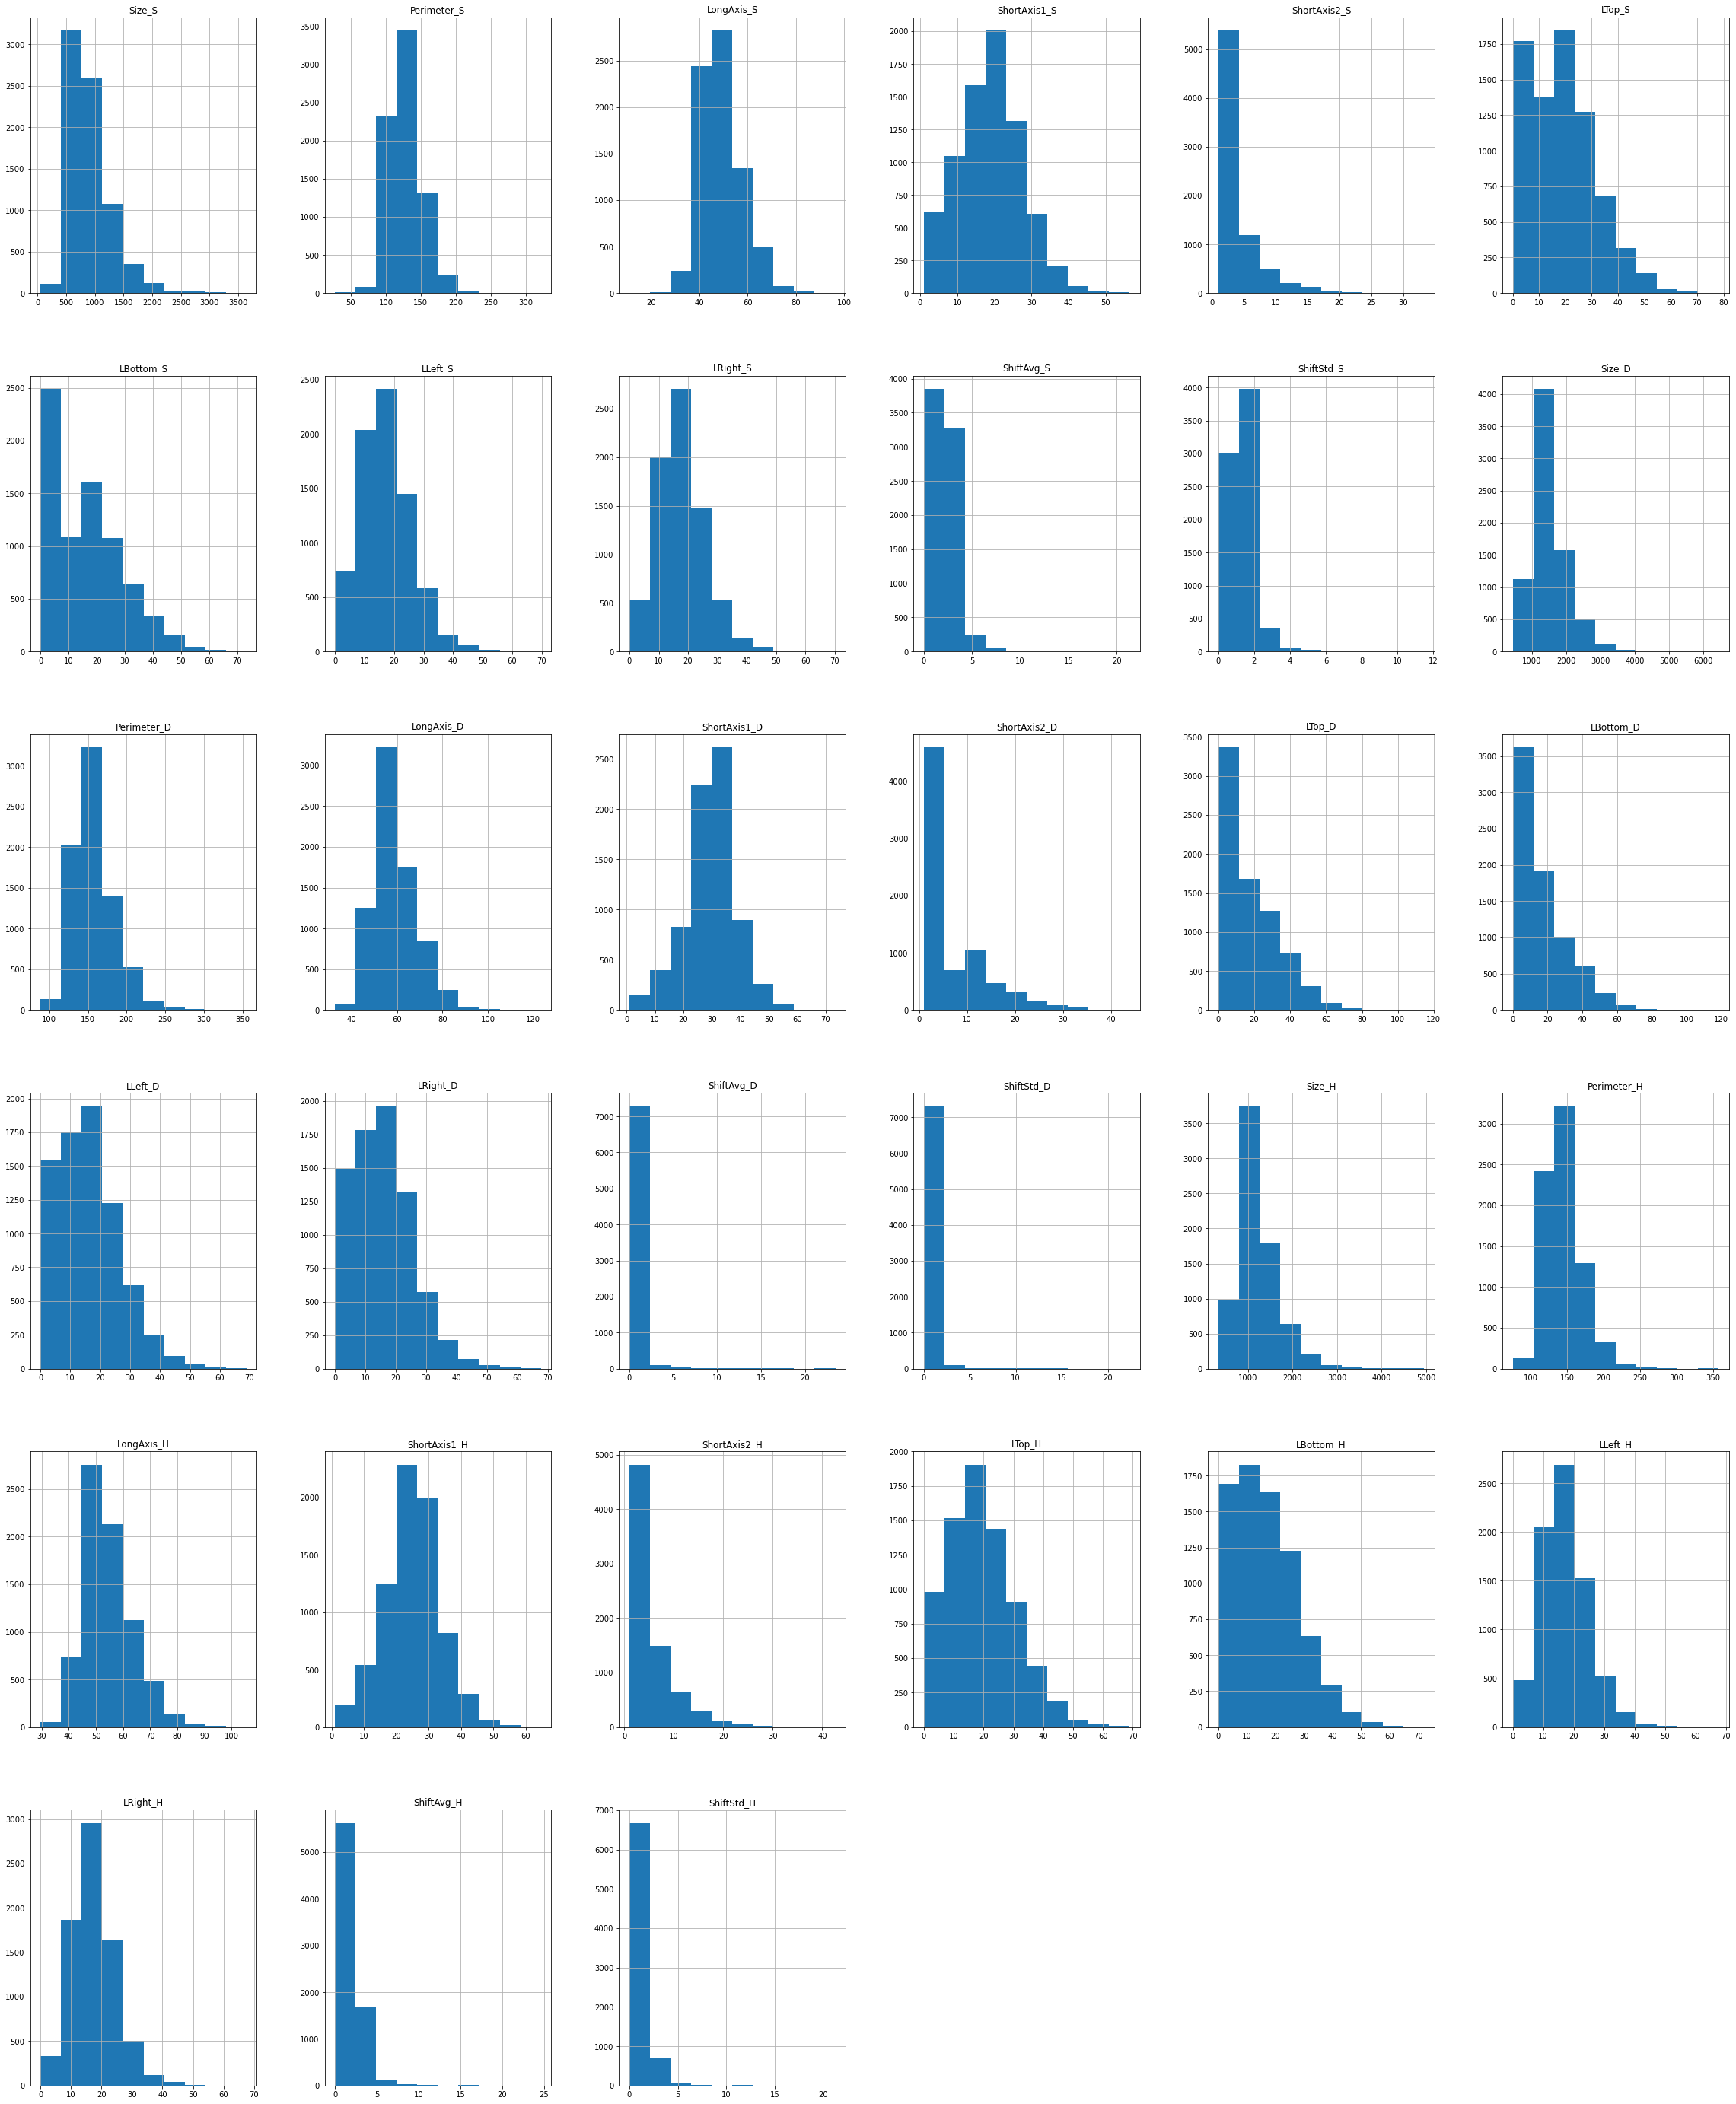

In [25]:
import matplotlib.pyplot as plt
train_features.hist(figsize=(40,50))  # s is an instance of Series
plt.savefig("G:\My Drive\EchoNet\output_boundary\histogram.png")

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,scoring='neg_mean_absolute_error')

    train_scores *= -1
    test_scores *=-1
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

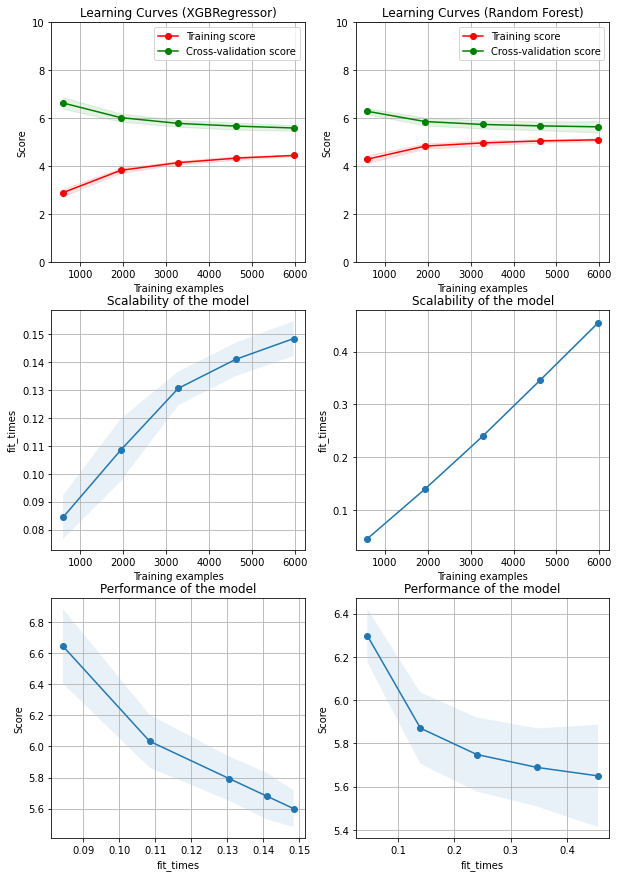

In [29]:
gig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = X_train,y_train

title = "Learning Curves (XGBRegressor)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = xgboost.XGBRegressor(random_state=1,n_estimators=10,max_depth=6)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0, 10),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (Random Forest)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestRegressor(n_estimators=10,random_state=1,max_depth=6)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0, 10),
                    cv=cv, n_jobs=4)

plt.show()